# LangChain Components 🦜️🔗 with Vertex AI and PaLM

## Objectives

This notebook provides an understanding of [Langchain](https://langchain.com/) components with Vertex PaLM APIs. Two components are covered in this notebook: **Models I/O and Retrieval**.

- Learn about LangChain and basic LangChain components
- Learn how to use Vertex AI with LangChain
- Learn how to call various Google LLM models using LangChain
- Learn how to create prompts and work with documents using LangChain


Topics covered in this notebook  
1. [Introduction to LangChain](#intro-to-langchain)
2. [LangChain Components](#langchain)
3. [Model I/O](#langchain-model-io) 
    - [Models](#langchain-models)
       - [Language Model](#langchain-models-language)
       - [Chat Model](#langchain-models-chat)
       - [Text Embedding Models](#langchain-models-text-embeddings)
    - [Prompts](#langchain-prompts)
       - [Prompt Template](#langchain-prompts-template)
       - [Example Selectors](#langchain-prompts-example-selectors)
    -  [Output Parsers](#langchain-prompts-output-parsers)
5. [Retrieval](#langchain-retrieval)
    - [Document Loaders](#langchain-indexes-document-loaders)
    - [Text Splitters](#langchain-indexes-text-splitters)
    - [Retrievers](#langchain-indexes-retrievers)
    - [Vector Stores](#langchain-indexes-vector-stores)





**Acknowledgment:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)


## What is LangChain? <a name="intro-to-langchain"/>

> LangChain is a framework for developing applications powered by large language models (LLMs).

**TL;DR** LangChain makes the complicated parts of working & building with language models easier. It helps do this in two ways:

1. **Integration** - Brings external data, such as your files, other applications, and API data, to LLMs
2. **Agents** - Allows LLMs to interact with its environment via decision making and use LLMs to help decide which action to take next

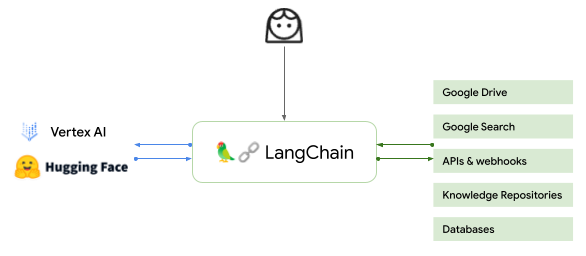


To build effective Generative AI applications, it is key to enable LLMs to interact with external systems. This makes models data-aware and agentic, meaning they can understand, reason, and use data to take action in a meaningful way. The external systems could be public data corpus, private knowledge repositories, databases, applications, APIs, or access to the public internet via Google Search.

Here are a few patterns where LLMs can be augmented with other systems:

- Convert natural language to SQL, executing the SQL on database, analyze and present the results
- Calling an external webhook or API based on the user query
- Synthesize outputs from multiple models, or chain the models in a specific order

It may look trivial to plumb these calls together and orchestrate them but it becomes a mundane task to write glue code again and again e.g. for every different data connector or a new model. That’s where LangChain comes in!

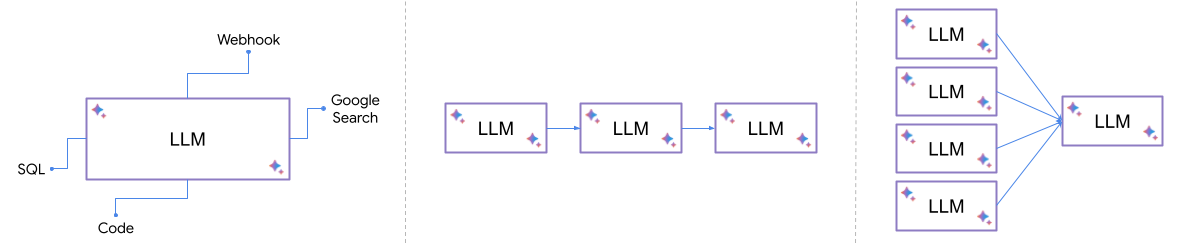


#### Why LangChain?

LangChain’s modular implementation of components and common patterns combining these components makes it easier to build complex applications based on LLMs. LangChain enables these models to connect to data sources and systems as agents to take action.

1. **Components** are abstractions that works to bring external data, such as your documents, databases, applications, APIs to language models. LangChain makes it easy to swap out abstractions and components necessary to work with LLMs.

2. **Agents** enable language models to communicate with its environment, where the model then decides the next action to take. LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

#### LangChain & Vertex AI

[Vertex AI PaLM foundational models](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) — Text, Chat, and Embeddings — are officially integrated with the LangChain, making it convenient to build applications on top of Vertex AI PaLM models. You can now create Generative AI applications by combining the power of Vertex PaLM models with the ease of use and flexibility of LangChain.

- [LangChain with Vertex AI PaLM for LLMs](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm)
- [LangChain with Vertex AI PaLM for Chat](https://python.langchain.com/docs/integrations/chat/google_vertex_ai_palm)
- [LangChain with Vertex AI Embedding API for Text](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)


### Setup

This lab needs a special kernel to run, please run the following cell. Then select the kernel `langchain_kernel` in the top right before going forward in the notebook.

In [ ]:
!cd ~/asl-ml-immersion && make langchain_kernel

### Import libraries


In [ ]:
PROJECT_ID = !gcloud config list --format 'value(core.project)'
PROJECT_ID = PROJECT_ID[0]
REGION = "us-central1"

In [ ]:
import time
from typing import List

# LangChain
import langchain
import vertexai
from langchain.chat_models import ChatVertexAI
from langchain.embeddings import VertexAIEmbeddings

# Utils
from langchain_google_vertexai import VertexAI
from pydantic import BaseModel

print(f"LangChain version: {langchain.__version__}")

# Vertex AI

print(f"Vertex AI SDK version: {vertexai.__version__}")

vertexai.init(project=PROJECT_ID, location=REGION)

Next you will define some utility functions that you will use for the Vertex AI Embeddings API. We will define a rate limiter to control the number of queries per minute issued to the API. Then we will derive a custom class from the parent class `VertexAIEmbeddings` in order to override its `embed_documents` method to wrap the API calls within that rate limiter.


In [ ]:
# Utility functions for Embeddings API with rate limiting


def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

Define LangChain Models using Vertex AI for Text, Chat and Embedding for Text


In [ ]:
llm = VertexAI(
    model_name="text-bison@002",
    max_output_tokens=1024,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# if you would like to use gemini-pro instead of PaLM uncomment this line
# llm = VertexAI(model_name="gemini-pro", temperature=0.1, max_tokens=None)

# Chat
chat = ChatVertexAI()  # default model: chat-bison

# Embedding
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

# LangChain Components <a name="langchain"/>

Let’s take a quick tour of LangChain framework and concepts to be aware of. LangChain offers a variety of modules that can be used to create language model applications. These modules can be combined to create more complex applications, or can be used individually for simpler applications.

- **Model I/O** are the building block of LangChain providing an interface to different types of AI models. Large Language Models (LLMs), Chat and Text Embeddings models are supported model types. Prompts refers to the input to the model, which is typically constructed from multiple components. LangChain provides interfaces to construct and work with prompts easily - Prompt Templates, Example Selectors and Output Parsers.
- **Retrieval** help LLMs interact with documents by providing a way to structure them. LangChain provides Document Loaders to load documents, Text Splitters to split documents into smaller chunks, Vector Stores to store documents as embeddings, and Retrievers to fetch relevant documents.
- **Composition** Higher-level components that combine other arbitrary systems and/or or LangChain primitives together. This includes, **memory** that provides a construct for storing and retrieving messages during a conversation which can be either short term or long term. **Chains** let you combine modular components (or other chains) in a specific order to complete a task. And, **agents** are a powerful construct in LangChain allowing LLMs to communicate with external systems via Tools and observe and decide on the best course of action to complete a given task.
- **Additional** includes Memory and Callbacks. Memory lets you persist application state between runs of a chain. And callbacks, let you log and stream steps in a workflow.


## Model I/O <a name="langchain-model-io"/>

The core element of any language model application is...the model. LangChain gives you the building blocks to interface with any language model.

### Models <a name="langchain-models"/>

LangChain supports 3 model primitives:

- LLMs
- Chat Models
- Text Embedding Models

VertexAI exposes all foundational models available in google cloud:

- Gemini (gemini-pro and gemini-pro-vision)
- Palm 2 for Text (text-bison)
- Codey for Code Generation (code-bison)
- Embeddings for Text (text-gecko)


### Language Model <a name="langchain-models-language"/>

Text is the natural language way to interact with LLMs. This is one of the fundamental ways to interact with LLMs. Let's start by asking the LLM some information. Language model provide a text in ➡️ text out interface! You can either use PaLM 2 or Gemini models to work with text input.

[LangChain LLMs](https://python.langchain.com/docs/integrations/llms/google_vertex_ai_palm) are integrated with [Vertex AI models](https://cloud.google.com/vertex-ai/docs/generative-ai/text/text-overview).


In [ ]:
my_text = "What are the different varieties of tomatoes?"

llm(my_text)

### Chat Model <a name="langchain-models-chat"/>

Chat is like text, but specified with a message type (System, Human, AI). ChatModel objects take a list of messages as input and output a message.

- **System** - Helpful context that tells the AI what to do. You can use system message to set the personality of the chatbot or even outline some rules the bot has to follow.
- **Human** - Messages that are sent to the LLM bu the user.
- **AI** - Responses that the LLM provides.

These message types can be helpful since they help keep track of who the message is from. For more information, see [LangChain Documentation for Chat Models](https://python.langchain.com/docs/modules/model_io/chat).

[LangChain Chat Model](https://python.langchain.com/en/latest/modules/models/chat/integrations/google_vertex_ai_palm.html) integrates with [Vertex AI models for chat](https://cloud.google.com/vertex-ai/docs/generative-ai/chat/chat-prompts).


In [ ]:
from langchain.schema import AIMessage, HumanMessage, SystemMessage

chat([HumanMessage(content="Hello")])

**Exercise**

Start a chat session but this time, with two messages:
- set the `SystemMessage` to set context that you are creating want the LLM to have the persona of a chef and to help you figure out recipes. 
- set the `HumanMessage` requesting for any kind of recipe.


In [ ]:
messages = None  # TODO
res = chat(messages)
print("Response from the Chat LLM:\n", res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("\nMessages history:\n", messages)

**Exercise**  
Continue the conversation with a new message

In [ ]:
messages.append("TODO - Enter prompt here")
res = chat(messages)
print(res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("Messages history:", messages)

In [ ]:
messages.append("TODO - Enter prompt here")
res = chat(messages)
print(res.content)
# adding the response from the LLM to the messages
messages.append(AIMessage(content=str(res.content)))
print("Messages history:", messages)

You can also pass more chat history with responses from the AI by appending the responses to the content as shown above.

### Text Embedding Model <a name="langchain-models-text-embeddings"/>

[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data–almost any kind of data, like text, images, videos, users, music, whatever–as points in space where the locations of those points in space are semantically meaningful. Embeddings transform your text into a vector (a series of numbers that hold the semantic 'meaning' of your text). Vectors are often used when comparing two pieces of text together. An [embedding](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) is a relatively low-dimensional space onto which you can translate high-dimensional vectors.

[LangChain Text Embedding Model](https://python.langchain.com/en/latest/modules/models/text_embedding/examples/google_vertex_ai_palm.html) integrate with [Vertex AI Embedding API for Text](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings).

_BTW: Semantic means 'relating to meaning in language or logic.'_


In [ ]:
text = "Tomato Soup"

**Exercise**  

Get the embedding for "Tomato Soup" using the embedding model and the `embed_query()` api. 

In [ ]:
text_embedding = #TODO
print(f"Your embedding is length {len(text_embedding)}")
print(f"Here's a sample: {text_embedding[:5]}...")

## Prompts <a name="langchain-prompts"/>

Prompts are text used as instructions to a LLM.

In [ ]:
prompt = """
Tomato is a vegetable.

What is wrong with that statement?
"""

llm(prompt)

### Prompt Template <a name="langchain-prompts-template"/>

[Prompt Template](https://python.langchain.com/v0.2/docs/concepts/#prompt-templates) is an object that helps create prompts based on a combination of user input, other non-static information and a fixed template string.

Think of it as an [f-string](https://realpython.com/python-f-strings/) in python but for prompts


**Exercise**  
Consider this prompt. How can you convert it to be more general so that the dish name can be replaced by the LLM. Create a prompt template for this.  

*"I really want to cook Brushetta. What is the recipe for it?
Respond with a simple recipe that is ideal for beginner cooks."*

In [ ]:
from langchain import PromptTemplate

# Notice "location" below, that is a placeholder for another value later
template = """
#TODO: Write the above prompt as a prompt template
"""

prompt = PromptTemplate(
    input_variables=["dish_name"],
    template=template,
)

final_prompt = prompt.format(dish_name="Bruschetta")

print(f"Final Prompt: {final_prompt}")
print("-----------")
print(f"LLM Output: {llm(final_prompt)}")

### Example Selectors <a name="langchain-prompts-example-selectors"/>

[Example selectors](https://python.langchain.com/v0.2/docs/concepts/#example-selectors) are an easy way to select from a series of examples to dynamically place in-context information into your prompt. Often used when the task is nuanced or has a large list of examples. Examples are provided when you want the LLM to understand what kind of answers you would like for it to provide. For example, in the code below we provide examples to the LLM about what certain fruits and vegetables taste. Then, we ask the LLM to tell us how a new fruit or vegetable tastes. 

Check out different types of example selectors [here](https://python.langchain.com/docs/modules/model_io/prompts/example_selectors/)


**Exercise**  

Add more examples of the same nature to the examples here.

In [ ]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.vectorstores import FAISS

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

# Some examples of how fruits or vegetables taste
examples = [
    {"input": "tomato", "output": "tangy"},
    {"input": "carrots", "output": "sweet"},
    # TODO: Add more fruits and vegetable examples
]

Now that we have provided a few examples, we will use `SemanticSimilarityExampleSelector`. This function will select examples that are semantically similar to the examples that we provided. [SemanticSimilarityExampleSelector](https://python.langchain.com/v0.1/docs/modules/model_io/prompts/example_selectors/similarity/) requires a list of examples (defined above), an embedding model (text-gecko) and the VectorStore Class in order to generate the result.

**Exercise**  

Call the `SemanticSimilarityExampleSelector()` you'll need examples, embeddings, the vector store (FAISS) and k as attributes.

In [ ]:
example_selector = #TODO: call the SemanticSimilarityExampleSelector

In [ ]:
similar_prompt = FewShotPromptTemplate(
    # The object that will help select examples
    example_selector=example_selector,
    # Your prompt
    example_prompt=example_prompt,
    # Customizations that will be added to the top and bottom of your prompt
    prefix="Give the way a vegetable/fruit taste",
    suffix="Input: {noun}\nOutput:",
    # What inputs your prompt will receive
    input_variables=["noun"],
)

In [ ]:
# Select a noun!
my_noun = "orange"

print(similar_prompt.format(noun=my_noun))

In [ ]:
llm(similar_prompt.format(noun=my_noun))

### Output Parsers <a name="langchain-prompts-output-parsers"/>

[Output Parsers](https://python.langchain.com/docs/modules/model_io/output_parsers/) responsible for taking the output of an LLM and transforming it to a more suitable format. This is very useful when you are asking the LLM to generate any form of structured data.

Two main ideas:

**1. Format Instructions**: An autogenerated prompt that tells the LLM how to format it's response based off desired result

**2. Parser**: A method to extract model's text output into a desired structure (usually json)

In the following cells, we'll take a look at `ResponseSchema` and `StructuredOutputParser`. This output parser can be used when you want to return multiple fields. While the Pydantic/JSON parser is more powerful, this is useful for less powerful models.


In [ ]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

In [ ]:
# How you would like your reponse structured. This is basically a fancy prompt template
response_schemas = [
    ResponseSchema(
        name="bad_string",
        description="This a poorly formatted user input string",
    ),
    ResponseSchema(
        name="good_string",
        description="This is your response, a reformatted response",
    ),
]

# How you would like to parse your output
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [ ]:
# See the prompt template you created for formatting
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

**Exercise**. 

Create a prompt template to ingest the badly formatted string and respond with the well formatted string 

In [ ]:
template = """
#TODO
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template,
)

promptValue = prompt.format(user_input="welcom to dbln!")

print(promptValue)

In [ ]:
llm_output = llm(promptValue)
llm_output

In [ ]:
output_parser.parse(llm_output)

## Retrieval <a name="langchain-retrieval"/>
 
Retrievals help you add structure documents as context to the LLMs.


### Documents <a name="langchain-components-documents"/>

Document in LangChain refers to an unstructured text consisting of `page_content` referring to the content of the data and `metadata` (data describing attributes of page content).


In [ ]:
from langchain.schema import Document

In [ ]:
Document(
    page_content="This is the recipe for a quick and easy tomato soup.",
    metadata={
        "page_number": 2,
        "recipe_source": "mom's recipe",
    },
)

### Document Loaders <a name="langchain-indexes-document-loaders"/>

Dcoument loaders are ways to import data from other sources. See the [large](https://python.langchain.com/v0.2/docs/integrations/document_loaders/) of document loaders here. Document loaders can be used to provide more context to the LLM especially data that the foundation LLM might not be trained on. This could be a webpage, a specific URL, an offline document etc. 


Here are a few examples of the loaders you can try. 


**HackerNews**

In [ ]:
from langchain.document_loaders import HNLoader  # HackerNews Loader

loader = HNLoader("https://news.ycombinator.com/item?id=34422627")
data = loader.load()
print(f"Found {len(data)} comments")
print(
    f"Here's a sample:\n\n{''.join([x.page_content[:150] for x in data[:2]])}"
)

**Books from Gutenberg Project**

In [ ]:
from langchain.document_loaders import GutenbergLoader

loader = GutenbergLoader("https://www.gutenberg.org/cache/epub/2148/pg2148.txt")

data = loader.load()

In [ ]:
print(data[0].page_content[1855:1984])

**URLs and webpages**

Let's try it out with [Andrew Ng's website](https://www.andrewng.org/)

In [ ]:
from langchain.document_loaders import UnstructuredURLLoader

urls = [
    "https://www.andrewng.org/",
]

loader = UnstructuredURLLoader(urls=urls)

webpage_data = loader.load()

webpage_data[0].page_content

### Text Splitters <a name="langchain-indexes-text-splitters"/>

[Text Splitters](https://python.langchain.com/docs/modules/data_connection/document_transformers/) are a way to deal with input token limits of LLMs by splitting text into chunks.

There are many ways you could split your text into chunks, experiment with [different ones](https://python.langchain.com/docs/modules/data_connection/document_transformers/) to see which is best for your use case.


**Exercise**  

Initialize the `RecursiveCharacterTextSplitter()` with chunk_size and chunk_overlap for the text splitter. We will be using this read the data from Andrew Ng's website.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = #TODO

texts = text_splitter.split_documents(webpage_data)

In [ ]:
print(f"You have {len(texts)} documents")

In [ ]:
print("Preview:")
print(texts[0].page_content, "\n")
print(texts[1].page_content)

### Retrievers <a name="langchain-indexes-retrievers"/>

[Retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers) are a way of storing data such that it can be queried by a language model. Easy way to combine documents with language models.

There are [many different types of retrievers](https://python.langchain.com/docs/modules/data_connection/retrievers.html#advanced-retrieval-types), the most widely supported is the `VectorStoreRetriever`.


Here we use [Facebook AI Similarity Search (FAISS)](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/), a library and a vector database for similarity search and clustering of dense vectors. To generate dense vectors, a.k.a. embeddings, we use [LangChain text embeddings model with Vertex AI Embeddings for Text](https://python.langchain.com/docs/integrations/text_embedding/google_vertex_ai_palm) .


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

In [ ]:
# Get your splitter ready
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=50
)

# Split your docs into texts
texts = text_splitter.split_documents(webpage_data)

# Embed your texts
db = FAISS.from_documents(texts, embeddings)

**Exercise**  

Initialize the retriever using `as.retriever()`

In [ ]:
# Init your retriever. Asking for just 1 document back
retriever = #TODO
retriever

In [ ]:
docs = retriever.get_relevant_documents(
    "what types of things did the author want to develop or build?"
)

print("\n\n".join([x.page_content[:200] for x in docs[:2]]))

### VectorStores <a name="langchain-indexes-vector-stores"/>

[Vector Store](https://python.langchain.com/docs/modules/data_connection/vectorstores) is a common type of database to store vectors (numerical embeddings). Conceptually, think of them as tables with a column for embeddings (vectors) and a column for metadata.

Example

| Embedding                                             | Metadata           |
| ----------------------------------------------------- | ------------------ |
| `[-0.00015641732898075134, -0.003165106289088726, ...]` | `{'date' : '1/2/23}` |
| `[-0.00035465431654651654, 1.4654131651654516546, ...]` | `{'date' : '1/3/23}` |

- [Chroma](https://www.trychroma.com/) & [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) are easy to work with locally.
- [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview) is fully managed vector store on Google Cloud, developers can just add the embeddings to its index and issue a search query with a key embedding for the blazingly fast vector search.

<br/>

**[LangChain VectorStore is integrated with Vertex AI Vector Search](https://python.langchain.com/docs/integrations/vectorstores/google_vertex_ai_vector_search).**


In [ ]:
# Split your docs into texts
texts = text_splitter.split_documents(webpage_data)

In [ ]:
print(f"You have {len(texts)} documents")

**Exercise**  

Embed the documents using `embed_documents()`.

In [ ]:
embedding_list = #TODO

In [ ]:
print(f"You have {len(embedding_list)} embeddings")
print(f"Here's a sample of one: {embedding_list[0][:3]}...")

Vectorstore stores your embeddings (☝️) and make them easily searchable.


Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.